<a href="https://colab.research.google.com/github/ABradham/ABradham/blob/main/COSC_074_Final_Project_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COSC 074 Final Project

## Document Imports

In [38]:
# Document Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Sklearn imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score, roc_curve, plot_roc_curve, ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import silhouette_score, rand_score
from sklearn.cluster import KMeans


## Binary Classifiers For Reviews >= 1 Stars

### Data Loading / Cleaning and Label Changes 

In [55]:
# Load data from CSV into dataframe
all_train  = pd.read_csv("./Training.csv")
all_test = pd.read_csv("./Test.csv")
all_train_review_text = all_train["reviewText"]
all_train_labels = all_train["overall"]
all_test_review_text = all_test["reviewText"]

# Convert labels fron 1-5 scale to 0-1 scale with cutoff @ 1
def change_labels(x):
    if x <= 1:
        return 0
    else:
        return 1
f = np.vectorize(change_labels)
all_train_labels = f(all_train_labels)

### Text Vectorization

In [56]:
# Initalize vectorizer. 
vectorizer = TfidfVectorizer(lowercase=True)

# Fit vectorizer and transform text into features 
all_text_features = vectorizer.fit_transform(all_train_review_text)
test_data_features = vectorizer.transform(all_test_review_text)

### Evaluation Metric Imports and Setup

In [57]:
# F1 Evaluation Function from example
def evaluate(labels, predictions):
    assert len(labels) == len(predictions), 'labels array and predictions array must be the same length'
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)
    return accuracy, precision, recall, f1


### Train-Test Split and 5 Fold Cross Validation For Logistic Regression

(C: 1, penalty: l2, class_weight: balanced): 0.734914577198418
(C: 1, penalty: l2, class_weight: None): 0.6731927665465262
(C: 1.5, penalty: l2, class_weight: balanced): 0.7355875257267327
(C: 1.5, penalty: l2, class_weight: None): 0.6882142733712865
(C: 2, penalty: l2, class_weight: balanced): 0.736846934112194
(C: 2, penalty: l2, class_weight: None): 0.6974642726632982
---Best Model Stats---
Best Model: {'C': 2, 'penalty': 'l2', 'class_weight': 'balanced'}
f1: 0.736846934112194
Accuracy 0.8068110938694651
AUC 0.7720390965300326
Confusion Matrix


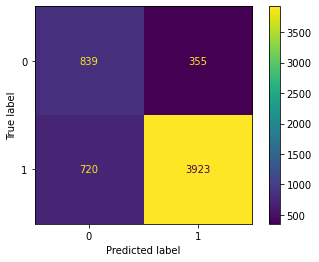

In [42]:
# Set range of hyperparameters to test
hyper_parameters = {"C": [1, 1.5, 2], "penalty": ["l1", "l2"], "class_weight": ['balanced', None]}
best_params = {"C": None, "penalty": None, "Classifier": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for C in hyper_parameters["C"]:
  for penalty in hyper_parameters['penalty']:
    for class_weight in hyper_parameters['class_weight']:

      # Dont regularize if using L1 penalty because it takes too long to converge
      if(penalty == 'l1'):
        continue
      
      current_results = {'Accuracy' : [],
                'Precision' : [],
                'Recall' : [],
                'F1' : [],
                'Confusion Matrix': [],
                'AUC': [],
                'ROC':[],
                'Classifier': []}
      # 5 Fold Cross Validation for each combination of hyperparameters
      kf = KFold(n_splits=5, shuffle=True, random_state=5)
      for train_index, test_index in kf.split(all_text_features):
          X_train, X_test = all_text_features[train_index], all_text_features[test_index]
          y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
          
          # Train model given this split
          log_reg_model = LogisticRegression(max_iter=300, solver="saga", penalty=penalty, class_weight=class_weight, C=C)
          log_reg_model.fit(X_train, y_train)
          
          # Calculate and report accuracy of this subset trained model
          labels = y_test.tolist()
          predictions = [log_reg_model.predict(current_vector) for current_vector in X_test]

          a, p, r, f = evaluate(labels, predictions)
          current_confusion_matrix = confusion_matrix(labels, predictions)
          current_AUC_score = roc_auc_score(labels, predictions)
          fpr, tpr, thresholds = roc_curve(labels, predictions)

          current_results['Accuracy'].append(a)
          current_results['Precision'].append(p)
          current_results['Recall'].append(r)
          current_results['F1'].append(f)
          current_results['Confusion Matrix'].append(current_confusion_matrix)
          current_results['AUC'].append(current_AUC_score)
          current_results['Classifier'].append(log_reg_model)

      # Calculate F1 Average for this set of hyperparameters and print results
      current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
      print(f"(C: {C}, penalty: {penalty}, class_weight: {class_weight}):", current_f1_avg)

      # Update best params if best f1 achieved
      if current_f1_avg > best_f1:
        best_f1 = current_f1_avg
        best_params = {"C": C, "penalty": penalty, "class_weight": class_weight}

        # Update best parameter metrics
        best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
        best_param_stats['AUC'] = np.mean(current_results['AUC'])
        best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f"f1: {best_f1}")
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation For Multinomial Naïeve Bayes

(alpha: 1) 0.44717749597572237
(alpha: 2) 0.4446850981933096


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(alpha: 3) 0.44381505961211987
---Best Model Stats---
Best Model: {'alpha': 1}
f1: 0.44717749597572237
Accuracy 0.7960532985784944
AUC 0.5015876201344983
Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


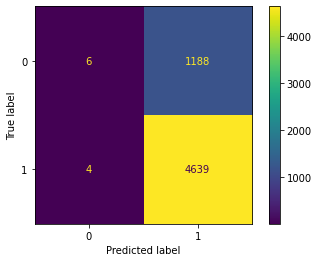

In [58]:
# Set range of hyperparameters to test
hyper_parameters = {"alpha": [1, 2, 3]}
best_params = {"alpha": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for alpha in hyper_parameters["alpha"]:
  current_results = {'Accuracy' : [],
            'Precision' : [],
            'Recall' : [],
            'F1' : [],
            'Confusion Matrix': [],
            'AUC': [],
            'ROC':[]}
  # 5 Fold Cross Validation for each combination of hyperparameters
  kf = KFold(n_splits=5, shuffle=True, random_state=5)
  for train_index, test_index in kf.split(all_text_features):
      X_train, X_test = all_text_features[train_index], all_text_features[test_index]
      y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
      
      # Train model given this split
      clf = MultinomialNB(alpha=alpha)
      clf.fit(X_train, y_train)
      
      # Calculate and report accuracy of this subset trained model
      labels = y_test.tolist()
      predictions = [clf.predict(current_vector) for current_vector in X_test]

      a, p, r, f = evaluate(labels, predictions)
      current_confusion_matrix = confusion_matrix(labels, predictions)
      current_AUC_score = roc_auc_score(labels, predictions)
      fpr, tpr, thresholds = roc_curve(labels, predictions)

      current_results['Accuracy'].append(a)
      current_results['Precision'].append(p)
      current_results['Recall'].append(r)
      current_results['F1'].append(f)
      current_results['Confusion Matrix'].append(current_confusion_matrix)
      current_results['AUC'].append(current_AUC_score)
      current_results['ROC'].append((fpr, tpr, thresholds))

  # Calculate F1 Average for this set of hyperparameters and print results
  current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
  print(f"(alpha: {alpha})", current_f1_avg)

  # Update best params if best f1 achieved
  if current_f1_avg > best_f1:
    best_f1 = current_f1_avg
    best_params = {"alpha": alpha}

    # Update best parameter metrics
    best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
    best_param_stats['AUC'] = np.mean(current_results['AUC'])
    best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]
    best_param_stats['ROC'] = current_results['ROC'][4]

# Calculate and print AUC-ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation Support Vector Machine Trained Via Stochastic Gradient Descent

(loss function: hinge, penalty: l1) 0.6057227115996712
(loss function: hinge, penalty: l2) 0.6420732196789605
(loss function: perceptron, penalty: l1) 0.6080118853127396
(loss function: perceptron, penalty: l2) 0.6741827825499163
---Best Model Stats---
Best Model: {'loss': 'perceptron', 'penalty': 'l2'}
f1: 0.6741827825499163
Accuracy 0.7935862543720132
AUC 0.6706971211986873
Confusion Matrix


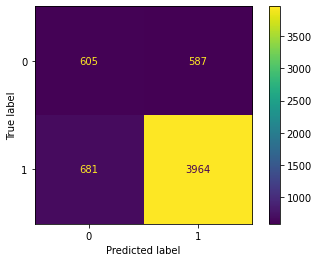

In [44]:
# Set range of hyperparameters to test
hyper_parameters = {"loss":["hinge", "perceptron"], "penalty":["l1", "l2"]}
best_params = {"loss": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for loss in hyper_parameters["loss"]:
  for penalty in hyper_parameters['penalty']:
      current_results = {'Accuracy' : [],
                'Precision' : [],
                'Recall' : [],
                'F1' : [],
                'Confusion Matrix': [],
                'AUC': [],
                'ROC':[]}
      # 5 Fold Cross Validation for each combination of hyperparameters
      kf = KFold(n_splits=5, shuffle=True, random_state=42)
      for train_index, test_index in kf.split(all_text_features):
          X_train, X_test = all_text_features[train_index], all_text_features[test_index]
          y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
          
          # Train model given this split
          clf = SGDClassifier(loss=loss, penalty=penalty)
          clf.fit(X_train, y_train)
          
          # Calculate and report accuracy of this subset trained model
          labels = y_test.tolist()
          predictions = [clf.predict(current_vector) for current_vector in X_test]

          a, p, r, f = evaluate(labels, predictions)
          current_confusion_matrix = confusion_matrix(labels, predictions)
          current_AUC_score = roc_auc_score(labels, predictions)
          fpr, tpr, thresholds = roc_curve(labels, predictions)

          current_results['Accuracy'].append(a)
          current_results['Precision'].append(p)
          current_results['Recall'].append(r)
          current_results['F1'].append(f)
          current_results['Confusion Matrix'].append(current_confusion_matrix)
          current_results['AUC'].append(current_AUC_score)
          current_results['ROC'].append((fpr, tpr, thresholds))

      # Calculate F1 Average for this set of hyperparameters and print results
      current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
      print(f"(loss function: {loss}, penalty: {penalty})", current_f1_avg)

      # Update best params if best f1 achieved
      if current_f1_avg > best_f1:
        best_f1 = current_f1_avg
        best_params = {"loss": loss, "penalty": penalty}

        # Update best parameter metrics
        best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
        best_param_stats['AUC'] = np.mean(current_results['AUC'])
        best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]
        best_param_stats['ROC'] = current_results['ROC'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == "Confusion Matrix":
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Training Best Model Found So Far (Logistic Regression)
For the binary classifier with star ratings >=1, the best model was logistic regression with C=2, penalty=l2, and class_weight=balanced. We use such a model to generate the predictions we send to kaggle.

In [45]:
# Train Classifier and Make Predictions
classifier = LogisticRegression(max_iter=300, solver="saga", penalty="l2", class_weight='balanced', C=2)
classifier.fit(all_text_features, all_train_labels)
predictions = classifier.predict(test_data_features)

# Save predicitons into a dataframe
df2 = pd.DataFrame(predictions)
df2.to_csv('predictions.csv', header=["predicted"])

## Binary Classifiers For Reviews >= 2 Stars

### Data Loading / Cleaning and Label Changes 

In [46]:
# Load data from CSV into dataframe
all_train  = pd.read_csv("./Training.csv")
all_test = pd.read_csv("./Test.csv")
all_train_review_text = all_train["reviewText"]
all_train_labels = all_train["overall"]
all_test_review_text = all_test["reviewText"]

# Convert labels fron 1-5 scale to 0-1 scale with cutoff @ 2
def change_labels(x):
    if x <= 2:
        return 0
    else:
        return 1
f = np.vectorize(change_labels)
all_train_labels = f(all_train_labels)

### Text Vectorization

In [47]:
# Initalize vectorizer. 
vectorizer = TfidfVectorizer(lowercase=True)

# Fit vectorizer and transform text into features 
all_text_features = vectorizer.fit_transform(all_train_review_text)
test_data_features = vectorizer.transform(all_test_review_text)

### Evaluation Metric Imports and Setup

In [48]:
# F1 Evaluation Function from example
def evaluate(labels, predictions):
    assert len(labels) == len(predictions), 'labels array and predictions array must be the same length'
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)
    return accuracy, precision, recall, f1


### Train-Test Split and 5 Fold Cross Validation For Logistic Regression

(C: 1, penalty: l2, class_weight: balanced): 0.7881298832386114
(C: 1, penalty: l2, class_weight: None): 0.7807543621953383
(C: 1.5, penalty: l2, class_weight: balanced): 0.7883177657315251
(C: 1.5, penalty: l2, class_weight: None): 0.7826584292991479
(C: 2, penalty: l2, class_weight: balanced): 0.7877784598579897
(C: 2, penalty: l2, class_weight: None): 0.782043201150276
---Best Model Stats---
Best Model: {'C': 1.5, 'penalty': 'l2', 'class_weight': 'balanced'}
f1: 0.7883177657315251
Accuracy 0.7934837846455991
AUC 0.791570087342113
Confusion Matrix


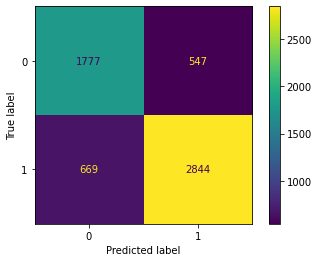

In [49]:
# Set range of hyperparameters to test
hyper_parameters = {"C": [1, 1.5, 2], "penalty": ["l1", "l2"], "class_weight": ['balanced', None]}
best_params = {"C": None, "penalty": None, "Classifier": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for C in hyper_parameters["C"]:
  for penalty in hyper_parameters['penalty']:
    for class_weight in hyper_parameters['class_weight']:

      # Dont regularize if using L1 penalty because it takes too long to converge
      if(penalty == 'l1'):
        continue
      
      current_results = {'Accuracy' : [],
                'Precision' : [],
                'Recall' : [],
                'F1' : [],
                'Confusion Matrix': [],
                'AUC': [],
                'ROC':[],
                'Classifier': []}
      # 5 Fold Cross Validation for each combination of hyperparameters
      kf = KFold(n_splits=5, shuffle=True, random_state=5)
      for train_index, test_index in kf.split(all_text_features):
          X_train, X_test = all_text_features[train_index], all_text_features[test_index]
          y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
          
          # Train model given this split
          log_reg_model = LogisticRegression(max_iter=300, solver="saga", penalty=penalty, class_weight=class_weight, C=C)
          log_reg_model.fit(X_train, y_train)
          
          # Calculate and report accuracy of this subset trained model
          labels = y_test.tolist()
          predictions = [log_reg_model.predict(current_vector) for current_vector in X_test]

          a, p, r, f = evaluate(labels, predictions)
          current_confusion_matrix = confusion_matrix(labels, predictions)
          current_AUC_score = roc_auc_score(labels, predictions)
          fpr, tpr, thresholds = roc_curve(labels, predictions)

          current_results['Accuracy'].append(a)
          current_results['Precision'].append(p)
          current_results['Recall'].append(r)
          current_results['F1'].append(f)
          current_results['Confusion Matrix'].append(current_confusion_matrix)
          current_results['AUC'].append(current_AUC_score)
          current_results['Classifier'].append(log_reg_model)

      # Calculate F1 Average for this set of hyperparameters and print results
      current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
      print(f"(C: {C}, penalty: {penalty}, class_weight: {class_weight}):", current_f1_avg)

      # Update best params if best f1 achieved
      if current_f1_avg > best_f1:
        best_f1 = current_f1_avg
        best_params = {"C": C, "penalty": penalty, "class_weight": class_weight}

        # Update best parameter metrics
        best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
        best_param_stats['AUC'] = np.mean(current_results['AUC'])
        best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f"f1: {best_f1}")
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation For Multinomial Naïeve Bayes

(alpha: 1) 0.6072298557443851
(alpha: 2) 0.526932582445241
(alpha: 3) 0.4875712919547497
---Best Model Stats---
Best Model: {'alpha': 1}
f1: 0.6072298557443851
Accuracy 0.6922472986147659
AUC 0.6280184145492959
Confusion Matrix


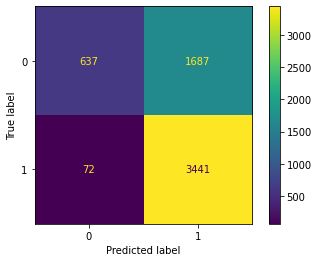

In [51]:
# Set range of hyperparameters to test
hyper_parameters = {"alpha": [1, 2, 3]}
best_params = {"alpha": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for alpha in hyper_parameters["alpha"]:
  current_results = {'Accuracy' : [],
            'Precision' : [],
            'Recall' : [],
            'F1' : [],
            'Confusion Matrix': [],
            'AUC': [],
            'ROC':[]}
  # 5 Fold Cross Validation for each combination of hyperparameters
  kf = KFold(n_splits=5, shuffle=True, random_state=5)
  for train_index, test_index in kf.split(all_text_features):
      X_train, X_test = all_text_features[train_index], all_text_features[test_index]
      y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
      
      # Train model given this split
      clf = MultinomialNB(alpha=alpha)
      clf.fit(X_train, y_train)
      
      # Calculate and report accuracy of this subset trained model
      labels = y_test.tolist()
      predictions = [clf.predict(current_vector) for current_vector in X_test]

      a, p, r, f = evaluate(labels, predictions)
      current_confusion_matrix = confusion_matrix(labels, predictions)
      current_AUC_score = roc_auc_score(labels, predictions)
      fpr, tpr, thresholds = roc_curve(labels, predictions)

      current_results['Accuracy'].append(a)
      current_results['Precision'].append(p)
      current_results['Recall'].append(r)
      current_results['F1'].append(f)
      current_results['Confusion Matrix'].append(current_confusion_matrix)
      current_results['AUC'].append(current_AUC_score)
      current_results['ROC'].append((fpr, tpr, thresholds))

  # Calculate F1 Average for this set of hyperparameters and print results
  current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
  print(f"(alpha: {alpha})", current_f1_avg)

  # Update best params if best f1 achieved
  if current_f1_avg > best_f1:
    best_f1 = current_f1_avg
    best_params = {"alpha": alpha}

    # Update best parameter metrics
    best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
    best_param_stats['AUC'] = np.mean(current_results['AUC'])
    best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]
    best_param_stats['ROC'] = current_results['ROC'][4]

# Calculate and print AUC-ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation Support Vector Machine Trained Via Stochastic Gradient Descent

(loss function: hinge, penalty: l1) 0.7722444097777388
(loss function: hinge, penalty: l2) 0.7826840835184641
(loss function: perceptron, penalty: l1) 0.675081513087067
(loss function: perceptron, penalty: l2) 0.7245350039006307
---Best Model Stats---
Best Model: {'loss': 'hinge', 'penalty': 'l2'}
f1: 0.7826840835184641
Accuracy 0.7938608549270132
AUC 0.7785413741205075
Confusion Matrix


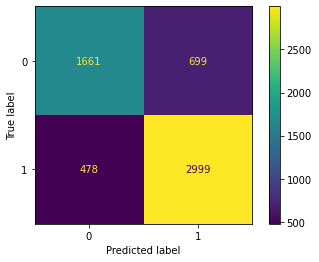

In [52]:
# Set range of hyperparameters to test
hyper_parameters = {"loss":["hinge", "perceptron"], "penalty":["l1", "l2"]}
best_params = {"loss": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for loss in hyper_parameters["loss"]:
  for penalty in hyper_parameters['penalty']:
      current_results = {'Accuracy' : [],
                'Precision' : [],
                'Recall' : [],
                'F1' : [],
                'Confusion Matrix': [],
                'AUC': [],
                'ROC':[]}
      # 5 Fold Cross Validation for each combination of hyperparameters
      kf = KFold(n_splits=5, shuffle=True, random_state=42)
      for train_index, test_index in kf.split(all_text_features):
          X_train, X_test = all_text_features[train_index], all_text_features[test_index]
          y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
          
          # Train model given this split
          clf = SGDClassifier(loss=loss, penalty=penalty)
          clf.fit(X_train, y_train)
          
          # Calculate and report accuracy of this subset trained model
          labels = y_test.tolist()
          predictions = [clf.predict(current_vector) for current_vector in X_test]

          a, p, r, f = evaluate(labels, predictions)
          current_confusion_matrix = confusion_matrix(labels, predictions)
          current_AUC_score = roc_auc_score(labels, predictions)
          fpr, tpr, thresholds = roc_curve(labels, predictions)

          current_results['Accuracy'].append(a)
          current_results['Precision'].append(p)
          current_results['Recall'].append(r)
          current_results['F1'].append(f)
          current_results['Confusion Matrix'].append(current_confusion_matrix)
          current_results['AUC'].append(current_AUC_score)
          current_results['ROC'].append((fpr, tpr, thresholds))

      # Calculate F1 Average for this set of hyperparameters and print results
      current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
      print(f"(loss function: {loss}, penalty: {penalty})", current_f1_avg)

      # Update best params if best f1 achieved
      if current_f1_avg > best_f1:
        best_f1 = current_f1_avg
        best_params = {"loss": loss, "penalty": penalty}

        # Update best parameter metrics
        best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
        best_param_stats['AUC'] = np.mean(current_results['AUC'])
        best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]
        best_param_stats['ROC'] = current_results['ROC'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == "Confusion Matrix":
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Training Best Model Found So Far (Logistic Regression)
For the binary classifier with star ratings >=2, the best model was logistic regression with C=1.5, penalty=l2, and class_weight=balanced. We use such a model to generate the predictions we send to kaggle.

In [54]:
# Train Classifier and Make Predictions
classifier = LogisticRegression(max_iter=300, solver="saga", penalty="l2", class_weight='balanced', C=1.5)
classifier.fit(all_text_features, all_train_labels)
predictions = classifier.predict(test_data_features)

# Save predicitons into a dataframe
df2 = pd.DataFrame(predictions)
df2.to_csv('predictions2.csv', header=["predicted"])

## Binary Classifiers For Reviews >= 3 Stars

### Data Loading / Cleaning and Label Changes 

In [59]:
# Load data from CSV into dataframe
all_train  = pd.read_csv("./Training.csv")
all_test = pd.read_csv("./Test.csv")
all_train_review_text = all_train["reviewText"]
all_train_labels = all_train["overall"]
all_test_review_text = all_test["reviewText"]

# Convert labels fron 1-5 scale to 0-1 scale with cutoff @ 3
def change_labels(x):
    if x <= 3:
        return 0
    else:
        return 1
f = np.vectorize(change_labels)
all_train_labels = f(all_train_labels)

### Text Vectorization

In [60]:
# Initalize vectorizer. 
vectorizer = TfidfVectorizer(lowercase=True)

# Fit vectorizer and transform text into features 
all_text_features = vectorizer.fit_transform(all_train_review_text)
test_data_features = vectorizer.transform(all_test_review_text)

### Evaluation Metric Imports and Setup

In [61]:
# F1 Evaluation Function from example
def evaluate(labels, predictions):
    assert len(labels) == len(predictions), 'labels array and predictions array must be the same length'
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)
    return accuracy, precision, recall, f1


### Train-Test Split and 5 Fold Cross Validation For Logistic Regression

(C: 1, penalty: l2, class_weight: balanced): 0.8043697303567896
(C: 1, penalty: l2, class_weight: None): 0.7976003024655389
(C: 1.5, penalty: l2, class_weight: balanced): 0.8045845765584787
(C: 1.5, penalty: l2, class_weight: None): 0.7996539484547368
(C: 2, penalty: l2, class_weight: balanced): 0.804174166785702
(C: 2, penalty: l2, class_weight: None): 0.8009198740556723
---Best Model Stats---
Best Model: {'C': 1.5, 'penalty': 'l2', 'class_weight': 'balanced'}
f1: 0.8045845765584787
Accuracy 0.8121549672814673
AUC 0.8078502396954269
Confusion Matrix


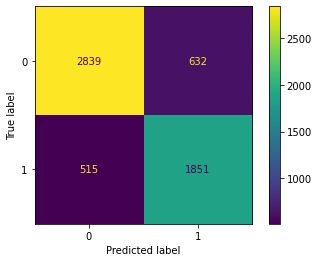

In [62]:
# Set range of hyperparameters to test
hyper_parameters = {"C": [1, 1.5, 2], "penalty": ["l1", "l2"], "class_weight": ['balanced', None]}
best_params = {"C": None, "penalty": None, "Classifier": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for C in hyper_parameters["C"]:
  for penalty in hyper_parameters['penalty']:
    for class_weight in hyper_parameters['class_weight']:

      # Dont regularize if using L1 penalty because it takes too long to converge
      if(penalty == 'l1'):
        continue
      
      current_results = {'Accuracy' : [],
                'Precision' : [],
                'Recall' : [],
                'F1' : [],
                'Confusion Matrix': [],
                'AUC': [],
                'ROC':[],
                'Classifier': []}
      # 5 Fold Cross Validation for each combination of hyperparameters
      kf = KFold(n_splits=5, shuffle=True, random_state=5)
      for train_index, test_index in kf.split(all_text_features):
          X_train, X_test = all_text_features[train_index], all_text_features[test_index]
          y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
          
          # Train model given this split
          log_reg_model = LogisticRegression(max_iter=300, solver="saga", penalty=penalty, class_weight=class_weight, C=C)
          log_reg_model.fit(X_train, y_train)
          
          # Calculate and report accuracy of this subset trained model
          labels = y_test.tolist()
          predictions = [log_reg_model.predict(current_vector) for current_vector in X_test]

          a, p, r, f = evaluate(labels, predictions)
          current_confusion_matrix = confusion_matrix(labels, predictions)
          current_AUC_score = roc_auc_score(labels, predictions)
          fpr, tpr, thresholds = roc_curve(labels, predictions)

          current_results['Accuracy'].append(a)
          current_results['Precision'].append(p)
          current_results['Recall'].append(r)
          current_results['F1'].append(f)
          current_results['Confusion Matrix'].append(current_confusion_matrix)
          current_results['AUC'].append(current_AUC_score)
          current_results['Classifier'].append(log_reg_model)

      # Calculate F1 Average for this set of hyperparameters and print results
      current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
      print(f"(C: {C}, penalty: {penalty}, class_weight: {class_weight}):", current_f1_avg)

      # Update best params if best f1 achieved
      if current_f1_avg > best_f1:
        best_f1 = current_f1_avg
        best_params = {"C": C, "penalty": penalty, "class_weight": class_weight}

        # Update best parameter metrics
        best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
        best_param_stats['AUC'] = np.mean(current_results['AUC'])
        best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f"f1: {best_f1}")
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation For Multinomial Naïeve Bayes

(alpha: 1) 0.557946608245316
(alpha: 2) 0.49650808114090383
(alpha: 3) 0.4728857752256571
---Best Model Stats---
Best Model: {'alpha': 1}
f1: 0.557946608245316
Accuracy 0.6797762886144743
AUC 0.5935206307077795
Confusion Matrix


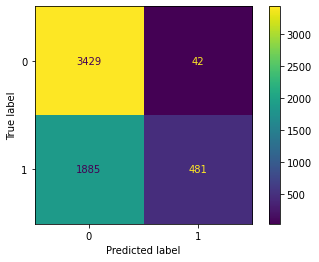

In [63]:
# Set range of hyperparameters to test
hyper_parameters = {"alpha": [1, 2, 3]}
best_params = {"alpha": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for alpha in hyper_parameters["alpha"]:
  current_results = {'Accuracy' : [],
            'Precision' : [],
            'Recall' : [],
            'F1' : [],
            'Confusion Matrix': [],
            'AUC': [],
            'ROC':[]}
  # 5 Fold Cross Validation for each combination of hyperparameters
  kf = KFold(n_splits=5, shuffle=True, random_state=5)
  for train_index, test_index in kf.split(all_text_features):
      X_train, X_test = all_text_features[train_index], all_text_features[test_index]
      y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
      
      # Train model given this split
      clf = MultinomialNB(alpha=alpha)
      clf.fit(X_train, y_train)
      
      # Calculate and report accuracy of this subset trained model
      labels = y_test.tolist()
      predictions = [clf.predict(current_vector) for current_vector in X_test]

      a, p, r, f = evaluate(labels, predictions)
      current_confusion_matrix = confusion_matrix(labels, predictions)
      current_AUC_score = roc_auc_score(labels, predictions)
      fpr, tpr, thresholds = roc_curve(labels, predictions)

      current_results['Accuracy'].append(a)
      current_results['Precision'].append(p)
      current_results['Recall'].append(r)
      current_results['F1'].append(f)
      current_results['Confusion Matrix'].append(current_confusion_matrix)
      current_results['AUC'].append(current_AUC_score)
      current_results['ROC'].append((fpr, tpr, thresholds))

  # Calculate F1 Average for this set of hyperparameters and print results
  current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
  print(f"(alpha: {alpha})", current_f1_avg)

  # Update best params if best f1 achieved
  if current_f1_avg > best_f1:
    best_f1 = current_f1_avg
    best_params = {"alpha": alpha}

    # Update best parameter metrics
    best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
    best_param_stats['AUC'] = np.mean(current_results['AUC'])
    best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]
    best_param_stats['ROC'] = current_results['ROC'][4]

# Calculate and print AUC-ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation Support Vector Machine Trained Via Stochastic Gradient Descent

(loss function: hinge, penalty: l1) 0.7852295468273024
(loss function: hinge, penalty: l2) 0.798018338359412
(loss function: perceptron, penalty: l1) 0.6773044956139851
(loss function: perceptron, penalty: l2) 0.7399323728062898
---Best Model Stats---
Best Model: {'loss': 'hinge', 'penalty': 'l2'}
f1: 0.798018338359412
Accuracy 0.8144504206224095
AUC 0.7898923092860866
Confusion Matrix


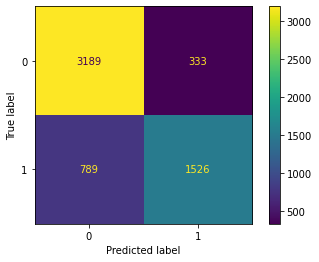

In [64]:
# Set range of hyperparameters to test
hyper_parameters = {"loss":["hinge", "perceptron"], "penalty":["l1", "l2"]}
best_params = {"loss": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for loss in hyper_parameters["loss"]:
  for penalty in hyper_parameters['penalty']:
      current_results = {'Accuracy' : [],
                'Precision' : [],
                'Recall' : [],
                'F1' : [],
                'Confusion Matrix': [],
                'AUC': [],
                'ROC':[]}
      # 5 Fold Cross Validation for each combination of hyperparameters
      kf = KFold(n_splits=5, shuffle=True, random_state=42)
      for train_index, test_index in kf.split(all_text_features):
          X_train, X_test = all_text_features[train_index], all_text_features[test_index]
          y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
          
          # Train model given this split
          clf = SGDClassifier(loss=loss, penalty=penalty)
          clf.fit(X_train, y_train)
          
          # Calculate and report accuracy of this subset trained model
          labels = y_test.tolist()
          predictions = [clf.predict(current_vector) for current_vector in X_test]

          a, p, r, f = evaluate(labels, predictions)
          current_confusion_matrix = confusion_matrix(labels, predictions)
          current_AUC_score = roc_auc_score(labels, predictions)
          fpr, tpr, thresholds = roc_curve(labels, predictions)

          current_results['Accuracy'].append(a)
          current_results['Precision'].append(p)
          current_results['Recall'].append(r)
          current_results['F1'].append(f)
          current_results['Confusion Matrix'].append(current_confusion_matrix)
          current_results['AUC'].append(current_AUC_score)
          current_results['ROC'].append((fpr, tpr, thresholds))

      # Calculate F1 Average for this set of hyperparameters and print results
      current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
      print(f"(loss function: {loss}, penalty: {penalty})", current_f1_avg)

      # Update best params if best f1 achieved
      if current_f1_avg > best_f1:
        best_f1 = current_f1_avg
        best_params = {"loss": loss, "penalty": penalty}

        # Update best parameter metrics
        best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
        best_param_stats['AUC'] = np.mean(current_results['AUC'])
        best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]
        best_param_stats['ROC'] = current_results['ROC'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == "Confusion Matrix":
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Training Best Model Found So Far (Logistic Regression)
For the binary classifier with star ratings >=3, the best model was logistic regression with C=1.5, penalty=l2, and class_weight=balanced. We use such a model to generate the predictions we send to kaggle.

In [65]:
# Train Classifier and Make Predictions
classifier = LogisticRegression(max_iter=300, solver="saga", penalty="l2", class_weight='balanced', C=1.5)
classifier.fit(all_text_features, all_train_labels)
predictions = classifier.predict(test_data_features)

# Save predicitons into a dataframe
df2 = pd.DataFrame(predictions)
df2.to_csv('predictions3.csv', header=["predicted"])

## Binary Classifiers For Reviews >= 4 Stars

### Data Loading / Cleaning and Label Changes 

In [66]:
# Load data from CSV into dataframe
all_train  = pd.read_csv("./Training.csv")
all_test = pd.read_csv("./Test.csv")
all_train_review_text = all_train["reviewText"]
all_train_labels = all_train["overall"]
all_test_review_text = all_test["reviewText"]

# Convert labels fron 1-5 scale to 0-1 scale with cutoff @ 2
def change_labels(x):
    if x <= 4:
        return 0
    else:
        return 1
f = np.vectorize(change_labels)
all_train_labels = f(all_train_labels)

### Text Vectorization

In [67]:
# Initalize vectorizer. 
vectorizer = TfidfVectorizer(lowercase=True)

# Fit vectorizer and transform text into features 
all_text_features = vectorizer.fit_transform(all_train_review_text)
test_data_features = vectorizer.transform(all_test_review_text)

### Evaluation Metric Imports and Setup

In [68]:
# F1 Evaluation Function from example
def evaluate(labels, predictions):
    assert len(labels) == len(predictions), 'labels array and predictions array must be the same length'
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)
    return accuracy, precision, recall, f1


### Train-Test Split and 5 Fold Cross Validation For Logistic Regression

(C: 1, penalty: l2, class_weight: balanced): 0.7623267325888081
(C: 1, penalty: l2, class_weight: None): 0.7061717305206779
(C: 1.5, penalty: l2, class_weight: balanced): 0.7620533914366721
(C: 1.5, penalty: l2, class_weight: None): 0.7193798992865983
(C: 2, penalty: l2, class_weight: balanced): 0.7614492968179029
(C: 2, penalty: l2, class_weight: None): 0.7234983781799517
---Best Model Stats---
Best Model: {'C': 1, 'penalty': 'l2', 'class_weight': 'balanced'}
f1: 0.7623267325888081
Accuracy 0.832059818749665
AUC 0.8015750500507304
Confusion Matrix


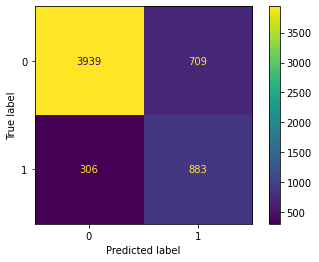

In [69]:
# Set range of hyperparameters to test
hyper_parameters = {"C": [1, 1.5, 2], "penalty": ["l1", "l2"], "class_weight": ['balanced', None]}
best_params = {"C": None, "penalty": None, "Classifier": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for C in hyper_parameters["C"]:
  for penalty in hyper_parameters['penalty']:
    for class_weight in hyper_parameters['class_weight']:

      # Dont regularize if using L1 penalty because it takes too long to converge
      if(penalty == 'l1'):
        continue
      
      current_results = {'Accuracy' : [],
                'Precision' : [],
                'Recall' : [],
                'F1' : [],
                'Confusion Matrix': [],
                'AUC': [],
                'ROC':[],
                'Classifier': []}
      # 5 Fold Cross Validation for each combination of hyperparameters
      kf = KFold(n_splits=5, shuffle=True, random_state=5)
      for train_index, test_index in kf.split(all_text_features):
          X_train, X_test = all_text_features[train_index], all_text_features[test_index]
          y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
          
          # Train model given this split
          log_reg_model = LogisticRegression(max_iter=300, solver="saga", penalty=penalty, class_weight=class_weight, C=C)
          log_reg_model.fit(X_train, y_train)
          
          # Calculate and report accuracy of this subset trained model
          labels = y_test.tolist()
          predictions = [log_reg_model.predict(current_vector) for current_vector in X_test]

          a, p, r, f = evaluate(labels, predictions)
          current_confusion_matrix = confusion_matrix(labels, predictions)
          current_AUC_score = roc_auc_score(y_test, log_reg_model.predict(X_test))

          current_results['Accuracy'].append(a)
          current_results['Precision'].append(p)
          current_results['Recall'].append(r)
          current_results['F1'].append(f)
          current_results['Confusion Matrix'].append(current_confusion_matrix)
          current_results['AUC'].append(current_AUC_score)
          current_results['Classifier'].append(log_reg_model)

      # Calculate F1 Average for this set of hyperparameters and print results
      current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
      print(f"(C: {C}, penalty: {penalty}, class_weight: {class_weight}):", current_f1_avg)

      # Update best params if best f1 achieved
      if current_f1_avg > best_f1:
        best_f1 = current_f1_avg
        best_params = {"C": C, "penalty": penalty, "class_weight": class_weight}

        # Update best parameter metrics
        best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
        best_param_stats['AUC'] = np.mean(current_results['AUC'])
        best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f"f1: {best_f1}")
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation For Multinomial Naïeve Bayes

(alpha: 1) 0.44817252378178846
(alpha: 2) 0.44714058695149017


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


(alpha: 3) 0.44642383193432983
---Best Model Stats---
Best Model: {'alpha': 1}
f1: 0.44817252378178846
Accuracy 0.8064678182317702
AUC 0.5005279635533999
Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


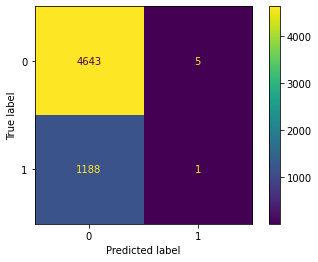

In [70]:
# Set range of hyperparameters to test
hyper_parameters = {"alpha": [1, 2, 3]}
best_params = {"alpha": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for alpha in hyper_parameters["alpha"]:
  current_results = {'Accuracy' : [],
            'Precision' : [],
            'Recall' : [],
            'F1' : [],
            'Confusion Matrix': [],
            'AUC': [],
            'ROC':[]}
  # 5 Fold Cross Validation for each combination of hyperparameters
  kf = KFold(n_splits=5, shuffle=True, random_state=5)
  for train_index, test_index in kf.split(all_text_features):
      X_train, X_test = all_text_features[train_index], all_text_features[test_index]
      y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
      
      # Train model given this split
      clf = MultinomialNB(alpha=alpha)
      clf.fit(X_train, y_train)
      
      # Calculate and report accuracy of this subset trained model
      labels = y_test.tolist()
      predictions = [clf.predict(current_vector) for current_vector in X_test]

      a, p, r, f = evaluate(labels, predictions)
      current_confusion_matrix = confusion_matrix(labels, predictions)
      current_AUC_score = roc_auc_score(y_test, clf.predict(X_test))

      current_results['Accuracy'].append(a)
      current_results['Precision'].append(p)
      current_results['Recall'].append(r)
      current_results['F1'].append(f)
      current_results['Confusion Matrix'].append(current_confusion_matrix)
      current_results['AUC'].append(current_AUC_score)
      current_results['ROC'].append((fpr, tpr, thresholds))

  # Calculate F1 Average for this set of hyperparameters and print results
  current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
  print(f"(alpha: {alpha})", current_f1_avg)

  # Update best params if best f1 achieved
  if current_f1_avg > best_f1:
    best_f1 = current_f1_avg
    best_params = {"alpha": alpha}

    # Update best parameter metrics
    best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
    best_param_stats['AUC'] = np.mean(current_results['AUC'])
    best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]
    best_param_stats['ROC'] = current_results['ROC'][4]

# Calculate and print AUC-ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation Support Vector Machine Trained Via Stochastic Gradient Descent

(loss function: hinge, penalty: l1) 0.6735349856462916
(loss function: hinge, penalty: l2) 0.6967096775287105
(loss function: perceptron, penalty: l1) 0.6630123412425947
(loss function: perceptron, penalty: l2) 0.6896253602848883
---Best Model Stats---
Best Model: {'loss': 'hinge', 'penalty': 'l2'}
f1: 0.6967096775287105
Accuracy 0.852889867552347
AUC 0.6618147048572165
Confusion Matrix


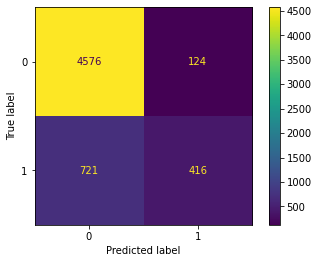

In [71]:
# Set range of hyperparameters to test
hyper_parameters = {"loss":["hinge", "perceptron"], "penalty":["l1", "l2"]}
best_params = {"loss": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for loss in hyper_parameters["loss"]:
  for penalty in hyper_parameters['penalty']:
      current_results = {'Accuracy' : [],
                'Precision' : [],
                'Recall' : [],
                'F1' : [],
                'Confusion Matrix': [],
                'AUC': [],
                'ROC':[]}
      # 5 Fold Cross Validation for each combination of hyperparameters
      kf = KFold(n_splits=5, shuffle=True, random_state=42)
      for train_index, test_index in kf.split(all_text_features):
          X_train, X_test = all_text_features[train_index], all_text_features[test_index]
          y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
          
          # Train model given this split
          clf = SGDClassifier(loss=loss, penalty=penalty)
          clf.fit(X_train, y_train)
          
          # Calculate and report accuracy of this subset trained model
          labels = y_test.tolist()
          predictions = [clf.predict(current_vector) for current_vector in X_test]

          a, p, r, f = evaluate(labels, predictions)
          current_confusion_matrix = confusion_matrix(labels, predictions)
          current_AUC_score = roc_auc_score(y_test, clf.predict(X_test))

          current_results['Accuracy'].append(a)
          current_results['Precision'].append(p)
          current_results['Recall'].append(r)
          current_results['F1'].append(f)
          current_results['Confusion Matrix'].append(current_confusion_matrix)
          current_results['AUC'].append(current_AUC_score)
          current_results['ROC'].append((fpr, tpr, thresholds))

      # Calculate F1 Average for this set of hyperparameters and print results
      current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
      print(f"(loss function: {loss}, penalty: {penalty})", current_f1_avg)

      # Update best params if best f1 achieved
      if current_f1_avg > best_f1:
        best_f1 = current_f1_avg
        best_params = {"loss": loss, "penalty": penalty}

        # Update best parameter metrics
        best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
        best_param_stats['AUC'] = np.mean(current_results['AUC'])
        best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]
        best_param_stats['ROC'] = current_results['ROC'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == "Confusion Matrix":
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'])
disp.plot()
plt.show()

### Training Best Model Found So Far (Logistic Regression)
For the binary classifier with star ratings >=4, the best model was logistic regression with C=1, penalty=l2, and class_weight=balanced. We use such a model to generate the predictions we send to kaggle.

In [72]:
# Train Classifier and Make Predictions
classifier = LogisticRegression(max_iter=300, solver="saga", penalty="l2", class_weight='balanced', C=1)
classifier.fit(all_text_features, all_train_labels)
predictions = classifier.predict(test_data_features)

# Save predicitons into a dataframe
df2 = pd.DataFrame(predictions)
df2.to_csv('predictions4.csv', header=["predicted"])

## Multiclass Classification for 1-5 Stars

### Data Loading / Cleaning and Label Changes 

In [73]:
# Load data from CSV into dataframe
all_train  = pd.read_csv("./Training.csv")
all_test = pd.read_csv("./Test.csv")
all_train_review_text = all_train["reviewText"]
all_train_labels = all_train["overall"]
all_test_review_text = all_test["reviewText"]

### Text Vectorization

In [74]:
# Initalize vectorizer. 
vectorizer = TfidfVectorizer(lowercase=True)

# Fit vectorizer and transform text into features 
all_text_features = vectorizer.fit_transform(all_train_review_text)
test_data_features = vectorizer.transform(all_test_review_text)

### Evaluation Metric Imports and Setup

In [75]:
# F1 Evaluation Function from example
def evaluate(labels, predictions):
    assert len(labels) == len(predictions), 'labels array and predictions array must be the same length'
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
    accuracy = accuracy_score(labels, predictions)
    return accuracy, precision, recall, f1


### Train-Test Split and 5 Fold Cross Validation For Logistic Regression

(C: 1, penalty: l2, class_weight: balanced): 0.46904124369058947
(C: 1, penalty: l2, class_weight: None): 0.4692828230958317
(C: 1.5, penalty: l2, class_weight: balanced): 0.46575015537694675
(C: 1.5, penalty: l2, class_weight: None): 0.4657245865368348
(C: 2, penalty: l2, class_weight: balanced): 0.4633385611923231
(C: 2, penalty: l2, class_weight: None): 0.46367954515807924
---Best Model Stats---
Best Model: {'C': 1, 'penalty': 'l2', 'class_weight': None}
f1: 0.4692828230958317
Accuracy 0.472643611535794
AUC 0.7942094675765727
Confusion Matrix


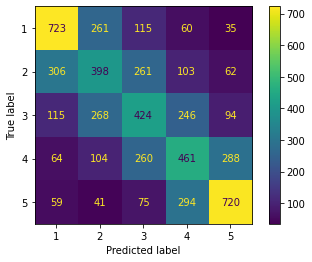

In [80]:
# Set range of hyperparameters to test
hyper_parameters = {"C": [1, 1.5, 2], "penalty": ["l1", "l2"], "class_weight": ['balanced', None]}
best_params = {"C": None, "penalty": None, "Classifier": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for C in hyper_parameters["C"]:
  for penalty in hyper_parameters['penalty']:
    for class_weight in hyper_parameters['class_weight']:

      # Dont regularize if using L1 penalty because it takes too long to converge
      if(penalty == 'l1'):
        continue
      
      current_results = {'Accuracy' : [],
                'Precision' : [],
                'Recall' : [],
                'F1' : [],
                'Confusion Matrix': [],
                'AUC': [],
                'ROC':[],
                'Classifier': []}
      # 5 Fold Cross Validation for each combination of hyperparameters
      kf = KFold(n_splits=5, shuffle=True, random_state=5)
      for train_index, test_index in kf.split(all_text_features):
          X_train, X_test = all_text_features[train_index], all_text_features[test_index]
          y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
          
          # Train model given this split
          log_reg_model = LogisticRegression(max_iter=300, solver="saga", penalty=penalty, class_weight=class_weight, C=C)
          log_reg_model.fit(X_train, y_train)
          
          # Calculate and report accuracy of this subset trained model
          labels = y_test.tolist()
          predictions = [log_reg_model.predict(current_vector) for current_vector in X_test]

          a, p, r, f = evaluate(labels, predictions)
          current_confusion_matrix = confusion_matrix(labels, predictions, labels=[1, 2, 3, 4, 5])
          current_AUC_score = roc_auc_score(y_test, log_reg_model.predict_proba(X_test), multi_class='ovr', labels=[1, 2, 3, 4, 5])

          current_results['Accuracy'].append(a)
          current_results['Precision'].append(p)
          current_results['Recall'].append(r)
          current_results['F1'].append(f)
          current_results['Confusion Matrix'].append(current_confusion_matrix)
          current_results['AUC'].append(current_AUC_score)
          current_results['Classifier'].append(log_reg_model)

      # Calculate F1 Average for this set of hyperparameters and print results
      current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
      print(f"(C: {C}, penalty: {penalty}, class_weight: {class_weight}):", current_f1_avg)

      # Update best params if best f1 achieved
      if current_f1_avg > best_f1:
        best_f1 = current_f1_avg
        best_params = {"C": C, "penalty": penalty, "class_weight": class_weight}

        # Update best parameter metrics
        best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
        best_param_stats['AUC'] = np.mean(current_results['AUC'])
        best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f"f1: {best_f1}")
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'], display_labels=['1', '2', '3', '4', '5'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation For Multinomial Naïeve Bayes

(alpha: 1) 0.42331319114162574
(alpha: 2) 0.4158063613463502
(alpha: 3) 0.4131029671760668
---Best Model Stats---
Best Model: {'alpha': 1}
f1: 0.42331319114162574
Accuracy 0.41937010023885735
AUC 0.767451996333641
Confusion Matrix


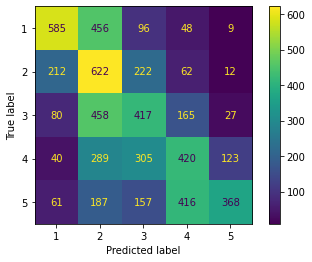

In [82]:
# Set range of hyperparameters to test
hyper_parameters = {"alpha": [1, 2, 3]}
best_params = {"alpha": None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for alpha in hyper_parameters["alpha"]:
  current_results = {'Accuracy' : [],
            'Precision' : [],
            'Recall' : [],
            'F1' : [],
            'Confusion Matrix': [],
            'AUC': [],
            'ROC':[]}
  # 5 Fold Cross Validation for each combination of hyperparameters
  kf = KFold(n_splits=5, shuffle=True, random_state=5)
  for train_index, test_index in kf.split(all_text_features):
      X_train, X_test = all_text_features[train_index], all_text_features[test_index]
      y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
      
      # Train model given this split
      clf = MultinomialNB(alpha=alpha)
      clf.fit(X_train, y_train)
      
      # Calculate and report accuracy of this subset trained model
      labels = y_test.tolist()
      predictions = [clf.predict(current_vector) for current_vector in X_test]

      a, p, r, f = evaluate(labels, predictions)
      current_confusion_matrix = confusion_matrix(labels, predictions, labels=[1, 2, 3, 4, 5])
      current_AUC_score = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr', labels=[1, 2, 3, 4, 5])

      current_results['Accuracy'].append(a)
      current_results['Precision'].append(p)
      current_results['Recall'].append(r)
      current_results['F1'].append(f)
      current_results['Confusion Matrix'].append(current_confusion_matrix)
      current_results['AUC'].append(current_AUC_score)

  # Calculate F1 Average for this set of hyperparameters and print results
  current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
  print(f"(alpha: {alpha})", current_f1_avg)

  # Update best params if best f1 achieved
  if current_f1_avg > best_f1:
    best_f1 = current_f1_avg
    best_params = {"alpha": alpha}

    # Update best parameter metrics
    best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
    best_param_stats['AUC'] = np.mean(current_results['AUC'])
    best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]

# Calculate and print AUC-ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == 'Confusion Matrix':
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'], display_labels=['1', '2', '3', '4', '5'])
disp.plot()
plt.show()

### Train-Test Split and 5 Fold Cross Validation Support Vector Machine Trained Via Stochastic Gradient Descent

(penalty: l1) 0.44724861744743966
(penalty: l2) 0.46731395225059097
---Best Model Stats---
Best Model: {'penalty': 'l2'}
f1: 0.46731395225059097
Accuracy 0.4772690112918598
AUC 0.7917967726653556
Confusion Matrix


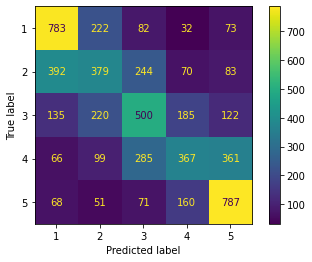

In [95]:
# Set range of hyperparameters to test
hyper_parameters = {"penalty": ['l1', 'l2']}
best_params = {'penalty': None}
best_f1 = np.NINF
best_param_stats = {"Accuracy": None, "AUC": None, "Confusion Matrix": None}

for penalty in hyper_parameters['penalty']:
    current_results = {'Accuracy' : [],
              'Precision' : [],
              'Recall' : [],
              'F1' : [],
              'Confusion Matrix': [],
              'AUC': [],
              'ROC':[]}
    # 5 Fold Cross Validation for each combination of hyperparameters
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_index, test_index in kf.split(all_text_features):
        X_train, X_test = all_text_features[train_index], all_text_features[test_index]
        y_train, y_test = all_train_labels[train_index], all_train_labels[test_index]
        
        # Train model given this split
        clf = SGDClassifier(loss="log", penalty=penalty)
        clf.fit(X_train, y_train)
        
        # Calculate and report accuracy of this subset trained model
        labels = y_test.tolist()
        predictions = [clf.predict(current_vector) for current_vector in X_test]

        a, p, r, f = evaluate(labels, predictions)
        current_confusion_matrix = confusion_matrix(labels, predictions, labels=[1, 2, 3, 4, 5])
        current_AUC_score = roc_auc_score(y_test, clf.predict_proba(X_test), multi_class="ovr", labels=[1, 2, 3, 4, 5])

        current_results['Accuracy'].append(a)
        current_results['Precision'].append(p)
        current_results['Recall'].append(r)
        current_results['F1'].append(f)
        current_results['Confusion Matrix'].append(current_confusion_matrix)
        current_results['AUC'].append(current_AUC_score)

    # Calculate F1 Average for this set of hyperparameters and print results
    current_f1_avg = sum(current_results['F1'])/len(current_results['F1'])
    print(f"(penalty: {penalty})", current_f1_avg)

    # Update best params if best f1 achieved
    if current_f1_avg > best_f1:
      best_f1 = current_f1_avg
      best_params = {"penalty": penalty}

      # Update best parameter metrics
      best_param_stats['Accuracy'] = np.mean(current_results['Accuracy'])
      best_param_stats['AUC'] = np.mean(current_results['AUC'])
      best_param_stats['Confusion Matrix'] = current_results['Confusion Matrix'][4]

# Calculate and print AUC, ROC, F1, Confusion Matrix, and Accuracy of the best model
print("---Best Model Stats---")
print("Best Model:", best_params)
print(f'f1: {best_f1}')
for key in best_param_stats:
  if key == 'ROC' or key == "Confusion Matrix":
    continue
  print(key, best_param_stats[key])
print("Confusion Matrix")
disp = ConfusionMatrixDisplay(confusion_matrix=best_param_stats['Confusion Matrix'], display_labels=['1', '2', '3', '4', '5'])
disp.plot()
plt.show()

### Training Best Model Found So Far (Logistic Regression)
For the multiclass classifier, the best model was logistic regression with C=1, penalty=l2, and class_weight=None. We use such a model to generate the predictions we send to kaggle.

In [96]:
# Train Classifier and Make Predictions
classifier = LogisticRegression(max_iter=300, solver="saga", penalty="l2", class_weight='balanced', C=1)
classifier.fit(all_text_features, all_train_labels)
predictions = classifier.predict(test_data_features)

# Save predicitons into a dataframe
df2 = pd.DataFrame(predictions)
df2.to_csv('predictions5.csv', header=["predicted"])

## Clustering

### Load Unlabeled (Test) Data

In [97]:
# Load data from CSV into dataframe
test_dataframe = pd.read_csv("./Test.csv")
test_text = test_dataframe["reviewText"]
test_labels = test_dataframe["category"]

### Vectorizing Review Text

In [98]:
# Initalize vectorizer. 
vectorizer = TfidfVectorizer(lowercase=True, max_df = 0.9, min_df = 0.2, stop_words='english')

# Fit vectorizer and transform text into features 
X = vectorizer.fit_transform(test_text)


### Run KMeans Algorithm




In [99]:
kmeans = KMeans(n_clusters=6).fit(X)
print("Silhouette Score:", silhouette_score(X, kmeans.labels_))
print("Rand Score", rand_score(test_labels, kmeans.labels_))

Silhouette Score: 0.9882771373157031
Rand Score 0.5295491837692327
